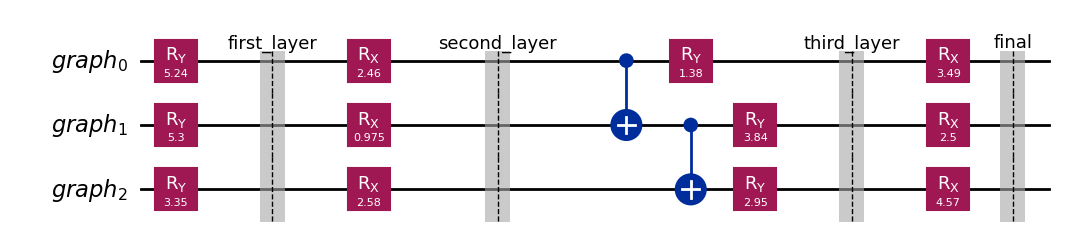

In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

# Qiskit Runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
from qiskit.circuit.library import MCPhaseGate
import numpy as np
from qiskit.quantum_info import Operator
N = 3
theta =2*np.pi* np.random.rand(4*N)


def var_qc(N,theta):
    
    hamiltonian = QuantumRegister(N, name="graph")


    qc = QuantumCircuit(hamiltonian)
    for i in range(N):
        qc.ry(theta[i], hamiltonian[i])
    qc.save_statevector(label=f'first_layer')
    for i in range(N):
        qc.rx(theta[i+N], hamiltonian[i])
    qc.save_statevector(label=f'second_layer')
    for i in range(N-1):
        qc.cx(i,i+1)
    for i in range(N):
        qc.ry(theta[i+2*N], hamiltonian[i])
    qc.save_statevector(label=f'third_layer')
    for i in range(N):
        qc.rx(theta[i+3*N], hamiltonian[i])
    qc.save_statevector(label=f'final')
    return qc

qc = var_qc(N,theta)
qc.draw(output="mpl", style='iqp', cregbundle=False)

In [12]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator,StatevectorSimulator
from qiskit.quantum_info import SparsePauliOp, Statevector
from numpy import linalg
import matplotlib.pyplot as plt

def grad_eval(N, N_layers, theta,eps,op):
    simulator = StatevectorSimulator()

    grad = np.zeros(N_layers*N)
    theta_plus = theta+eps
    theta_minus = theta-eps
    for it1 in range(N_layers*N):
        
        
        if theta_plus[it1] > 2*np.pi:
            theta_plus[it1] -= 2*np.pi
        elif theta_minus[it1]<0:
            theta_minus[it1] += 2*np.pi

        
        qc_plus = var_qc(N,theta_plus )
        qc_minus = var_qc(N,theta_minus )

        cc_plus = transpile(qc_plus,simulator)
        result_plus = simulator.run(cc_plus).result()
        statevector_plus = result_plus.get_statevector()

        cc_minus = transpile(qc_minus,simulator)
        result_minus = simulator.run(cc_minus).result()
        statevector_minus = result_minus.get_statevector()

        
        grad_el = (statevector_plus.expectation_value(op).real-statevector_minus.expectation_value(op).real)/(2*eps)
        
        grad[it1] = grad_el
    return grad

In [13]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator,StatevectorSimulator
from qiskit.quantum_info import SparsePauliOp, Statevector
from numpy import linalg
import matplotlib.pyplot as plt

D = 0.0801
B = 0.025
E = 1e4
t= 0.5*np.pi
#t = np.pi/2
N = 3
h = 1.055e-34;
delta = 2*np.pi*1.667e9
Kb = 1.38e-23;

me = 1.66 *3.336e-30
mb = 9.274e-24
B= mb*B/Kb
E = me *E/Kb
D = h*delta/Kb

ham = np.array([[-1/2*D - 6/5*B , 0 , 0 , 0 , 3/5*E*np.cos(t) , -np.sqrt(3)/5*E*np.sin(t) , 0,  0],[0 , -1/2*D - 2/5*B  ,0 , 0 , -np.sqrt(3)/5*E*np.sin(t) , 1/5*E*np.cos(t) , -2/5*E*np.sin(t) , 0],[0 , 0  ,-1/2*D + 2/5*B , 0 , 0 , -2/5*E*np.sin(t) , -1/5*E*np.cos(t) , -np.sqrt(3)/5*E*np.sin(t)],[ 0 , 0  ,0 , -1/2*D + 6/5*B , 0 , 0 , -np.sqrt(3)/5*E*np.sin(t) , -3/5*E*np.cos(t)],[3/5*E*np.cos(t) , -np.sqrt(3)/5*E*np.sin(t) , 0 , 0 , 1/2*D - 6/5*B , 0 , 0 , 0],[-np.sqrt(3)/5*E*np.sin(t) , 1/5*E*np.cos(t) , -2/5*E*np.sin(t) , 0 , 0 , 1/2*D - 2/5*B , 0 , 0],[ 0 , -2/5*E*np.sin(t) , -1/5*E*np.cos(t) , -np.sqrt(3)/5*E*np.sin(t) , 0 , 0 , 1/2*D + 2/5*B , 0],[0 , 0 , -np.sqrt(3)/5*E*np.sin(t) , -3/5*E*np.cos(t) , 0 , 0  ,0 , 1/2*D + 6/5*B]])
target_val = min(linalg.eigvals(ham))
print(target_val)
eps = 1e-4
eta = .1
simulator = StatevectorSimulator()
Max_it = 300
theta_nat =2*np.pi* np.random.rand(4*N)
theta = theta_nat
res_nat = []
res_vanilla = []
for it in range(Max_it):
    qc_nat = var_qc(N,theta_nat )

    #simulator = AerSimulator.from_backend(statevector_nat)
    cc_nat = transpile(qc_nat,simulator)
    result_nat = simulator.run(cc_nat).result()
    
    statevector_nat = result_nat.data(0)['final']
    
    



    op = Operator(ham)

    # Compute expectation value
    expectation_value_nat = statevector_nat.expectation_value(op).real
    
    I = np.eye(2)
    Y = np.array([[0,-1j],[1j,0]])
    X = np.array([[0,1],[1,0]])
    q = np.zeros(144).reshape(12,12)
    merged_sv = [result_nat.data(0)['first_layer'],result_nat.data(0)['second_layer'],result_nat.data(0)['third_layer'],result_nat.data(0)['final']]
    
    PY = [np.kron(np.kron(Y,I),I),np.kron(np.kron(I,Y),I),np.kron(np.kron(I,I),Y)]   
    PX = [np.kron(np.kron(X,I),I),np.kron(np.kron(I,X),I),np.kron(np.kron(I,I),X)]
    
    for layer in range(4):
        for it2 in range(3):
            for it3 in range(it2,3):
                if layer%2 ==0:
                    q[it2+layer*3,it3+layer*3]  = merged_sv[layer].expectation_value(Operator(PY[it2].dot(PY[it3]))).real -  (merged_sv[layer].expectation_value(Operator(PY[it2])).real)* (merged_sv[layer].expectation_value(Operator(PY[it3])).real ) 
                    q[it3+layer*3,it2+layer*3] = q[it2+layer*3,it3+layer*3]
                else:
                    q[it2+layer*3,it3+layer*3]  = merged_sv[layer].expectation_value(Operator(PX[it2].dot(PX[it3]))).real-  merged_sv[layer].expectation_value(Operator(PX[it2])).real* merged_sv[layer].expectation_value(Operator(PX[it3])).real  
                    q[it3+layer*3,it2+layer*3] = q[it2+layer*3,it3+layer*3]
    q = q*(1/4)
    g_plus = linalg.pinv(q)    
    
    grad_nat = grad_eval(N,4,theta_nat,eps,op)

    

    qc = var_qc(N,theta )

    #simulator = AerSimulator.from_backend(statevector)
    cc = transpile(qc,simulator)
    result = simulator.run(cc).result()
    statevector = result.get_statevector()
    



    

    # Compute expectation value
    expectation_value = statevector.expectation_value(op).real
    
    
    grad =  grad_eval(N,4,theta,eps,op)

    

    
    
   
    # Print result
    print("exp val nat:", expectation_value_nat, "exp val vanilla:",expectation_value,"iteration",it)
    res_vanilla.append(expectation_value)
    res_nat.append(expectation_value_nat)
    theta_nat = theta_nat-eta*(grad_nat.dot(g_plus))
    theta = theta-4*eta*grad
    for it1 in range(4*N):
        if theta[it1] > 2*np.pi:
            theta[it1] = theta[it1]-2*np.pi
        elif theta[it1]<0:
            theta[it1] = theta[it1]+2*np.pi
        if theta_nat[it1] > 2*np.pi:
            theta_nat[it1] = theta_nat[it1]-2*np.pi
        elif theta_nat[it1]<0:
            theta_nat[it1] = theta_nat[it1]+2*np.pi


x_vanilla = range(1,len(res_vanilla)+1)
x_nat = range(1,len(res_nat)+1)
res_target = target_val*np.ones(len(res_vanilla))
# Create the plot
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(x_vanilla, res_vanilla, linestyle='-', label='vanilla', color='b')  # Line for res1
plt.plot(x_nat, res_nat, linestyle='-', label='natural', color='r')  # Line for res2
plt.plot(x_vanilla,res_target, linestyle='--', label='target', color='g')
# Labels and title
plt.xlabel("Iterations")
plt.ylabel("Energy")


# Add legend
plt.legend()

# Show plot
plt.show()

-0.06021830290498996
exp val nat: -0.0044092418928065695 exp val vanilla: -0.0044092418928065695 iteration 0
exp val nat: -0.006469887226579798 exp val vanilla: -0.005439925320053005 iteration 1
exp val nat: -0.008745144865940902 exp val vanilla: -0.0065260970481449045 iteration 2
exp val nat: -0.01120444108486248 exp val vanilla: -0.00766161522566285 iteration 3
exp val nat: -0.01373178013544029 exp val vanilla: -0.008838931789065365 iteration 4
exp val nat: -0.0161453820920009 exp val vanilla: -0.01004932274301153 iteration 5
exp val nat: -0.01829182057383537 exp val vanilla: -0.011283200239353915 iteration 6
exp val nat: -0.020099855760373334 exp val vanilla: -0.01253047923394665 iteration 7
exp val nat: -0.021560584935703557 exp val vanilla: -0.013780964453326567 iteration 8
exp val nat: -0.022694602218216967 exp val vanilla: -0.015024722104729177 iteration 9
exp val nat: -0.023533774734006037 exp val vanilla: -0.016252405302399138 iteration 10
exp val nat: -0.024113794986004723 ex

KeyboardInterrupt: 

In [18]:
ham = np.array([[-1/2*D - 6/5*B , 0 , 0 , 0 , 3/5*E*np.cos(t) , -np.sqrt(3)/5*E*np.sin(t) , 0,  0],[0 , -1/2*D - 2/5*B  ,0 , 0 , -np.sqrt(3)/5*E*np.sin(t) , 1/5*E*np.cos(t) , -2/5*E*np.sin(t) , 0],[0 , 0  ,-1/2*D + 2/5*B , 0 , 0 , -2/5*E*np.sin(t) , -1/5*E*np.cos(t) , -np.sqrt(3)/5*E*np.sin(t)],[ 0 , 0  ,0 , -1/2*D + 6/5*B , 0 , 0 , -np.sqrt(3)/5*E*np.sin(t) , -3/5*E*np.cos(t)],[3/5*E*np.cos(t) , -np.sqrt(3)/5*E*np.sin(t) , 0 , 0 , 1/2*D - 6/5*B , 0 , 0 , 0],[-np.sqrt(3)/5*E*np.sin(t) , 1/5*E*np.cos(t) , -2/5*E*np.sin(t) , 0 , 0 , 1/2*D - 2/5*B , 0 , 0],[ 0 , -2/5*E*np.sin(t) , -1/5*E*np.cos(t) , -np.sqrt(3)/5*E*np.sin(t) , 0 , 0 , 1/2*D + 2/5*B , 0],[0 , 0 , -np.sqrt(3)/5*E*np.sin(t) , -3/5*E*np.cos(t) , 0 , 0  ,0 , 1/2*D + 6/5*B]])
print(min(linalg.eigvals(ham)))

-0.08363158991279387


In [7]:
print(res)

NameError: name 'res' is not defined